In [835]:
#automatically reload stuff
%reload_ext autoreload
%autoreload 2
from SymptomPreprocessing import *
from SpatialPreprocessing import *
import Cluster
import Metrics
import re
import Utils
from warnings import simplefilter 
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.decomposition import PCA
from scipy.stats import power_divergence, chisquare, chi2_contingency, pointbiserialr, pearsonr, fisher_exact

import statsmodels.api as sm

from xml.dom import minidom
from svgpath2mpl import parse_path
import matplotlib.patches as mpatches
import matplotlib.path as mpath
import matplotlib.transforms as mplt
import matplotlib as mpl

simplefilter(action='ignore')
pd.set_option('display.max_rows', 1000)

In [867]:
rds = RadDataset()
rds.get_value_array(rds.dvh_df.columns,as_df=True)

spellchecking...
renaming things
filtering pateints
adding nan values for missing organs
adding histograms


Esophagus_D80  Esophagus_D25  Esophagus_D35  Esophagus_D85  \
id                                                                  
2.0        29.187500      44.437500      41.031250      21.343750   
6.0         6.699219      41.437500      39.593750       4.390625   
7.0         5.000000      34.062500      32.281250       3.960938   
8.0         6.691406      30.609375      28.968750       6.320312   
9.0        22.515625      43.531250      39.156250      20.484375   
10.0        7.660156      40.718750      36.875000       6.511719   
11.0        6.730469      22.625000      14.148438       6.539062   
12.0        0.700195       2.160156       1.759766       0.600098   
13.0       14.031250      41.031250      40.312500       5.871094   
15.0       31.375000      42.031250      40.187500      29.031250   
16.0        0.020004      21.718750      20.312500       0.020004   
18.0       22.515625      43.531250      39.156250      20.484375   
19.0        4.679688      36.375000      33.843750       3.599609   
21.0       23.375000      42.593750      41.437500      12.382812   
22.0       21.265625      42.875000      41.843750      10.312500   
23.0       30.796875      42.062500      41.312500      22.562500   
24.0        6.351562      29.812500      27.984375       4.609375   
25.0        0.020004      23.796875      22.109375       0.020004   
28.0       22.515625      43.531250      39.156250      20.484375   
29.0       27.718750      39.218750      38.468750      15.632812   
31.0       22.515625      43.531250      39.156250      20.484375   
32.0        5.089844      13.039062       9.679688       4.738281   
34.0       22.515625      43.531250      39.156250      20.484375   
35.0       22.515625      43.531250      39.156250      20.484375   
37.0        9.382812      30.703125      27.015625       3.470703   
38.0        1.179688       3.939453       3.269531       1.040039   
39.0        9.531250      35.937500      35.406250       5.128906   
40.0        7.039062      36.562500      34.375000       6.109375   
41.0        2.380859      28.765625      26.765625       1.889648   
42.0        4.679688      32.218750      30.875000       3.400391   
43.0       20.625000      53.000000      45.968750      16.578125   
44.0        0.020004      20.312500      17.578125       0.020004   
45.0       22.515625      43.531250      39.156250      20.484375   
46.0       22.515625      43.531250      39.156250      20.484375   
47.0        3.130859      35.093750      31.828125       2.589844   
48.0       20.843750      46.093750      43.281250      19.250000   
49.0       22.515625      43.531250      39.156250      20.484375   
50.0       22.515625      43.531250      39.156250      20.484375   
51.0       11.687500      21.453125      20.890625       6.691406   
52.0        7.628906      34.718750      32.687500       7.449219   
53.0        6.921875      27.046875      24.406250       3.710938   
54.0        0.959961      16.187500      14.570312       0.580078   
56.0        0.020004      47.250000      39.593750       0.010002   
57.0        2.699219      20.484375      16.921875       2.289062   
58.0       22.515625      43.531250      39.156250      20.484375   
59.0       30.609375      39.906250      39.312500      29.640625   
60.0       11.679688      27.875000      26.546875      10.398438   
61.0       16.703125      47.187500      46.187500      11.398438   
62.0        0.340088       9.257812       7.808594       0.140015   
65.0        3.330078      26.296875      23.437500       2.609375   
67.0        4.359375      33.843750      29.718750       3.289062   
68.0        9.539062      30.484375      27.421875       8.453125   
69.0       12.179688      27.906250      21.765625       9.093750   
71.0       23.734375      37.187500      36.281250      14.968750   
72.0       22.515625      43.531250      39.156250      20.484375   
73.0       22.515625      43.531250      39.156250      20.484375   
76.0 

In [868]:
def rolled_up_dvh_valdf(rds,cols=None):
    #returns a dvh df with organ values rolled up nicely
    #note, currently uses string sort so idk how to make the order nice right now
    if cols == None:
        cols = rds.dvh_df.columns
    cols = sorted((set(cols) - set(['ROI','Structure','id'])).intersection(set(rds.dvh_df.columns)))
    vdf = rds.get_value_array(cols,as_df=True)
    olist = rds.organ_list
    print(len(olist))
    print(vdf)
    vallist=[]
    for col in list(cols):
        #organ values in order
        colnames = [o + '_' + col for o in olist]
        valdf = vdf[colnames].sort_index()
        vals = valdf.values.tolist()
        vallist.append(vals)
    valdf = pd.DataFrame(np.swapaxes(np.array(vallist),0,1).tolist(),index=vdf.index,columns=cols)
    return valdf

rolled_up_dvh_valdf(rds,cols=['D10','mean_dose'])

40
       Esophagus_D10  Esophagus_mean_dose  Spinal_Cord_D10  \
id                                                           
2.0        51.625000            35.720554        26.890625   
6.0        44.968750            30.499019        26.406250   
7.0        37.625000            22.765716        37.156250   
8.0        32.156250            19.083992        32.062500   
9.0        51.437500            33.666962        27.515625   
10.0       44.218750            27.220497        35.625000   
11.0       26.156250            13.436690        31.984375   
12.0        3.279297             1.584915        34.437500   
13.0       42.218750            31.537254        29.625000   
15.0       44.906250            35.636464        33.281250   
16.0       24.937500            15.118502        32.281250   
18.0       51.437500            33.666962        29.781250   
19.0       39.125000            20.922793        33.093750   
21.0       44.593750            33.483681        39.937500   
22.0 

D10  \
id                                                         
2.0    [51.625, 26.890625, 56.1875, 53.625, 53.75, 57...   
6.0    [44.96875, 26.40625, 61.71875, 56.78125, 55.18...   
7.0    [37.625, 37.15625, 60.3125, 66.3125, 49.4375, ...   
8.0    [32.15625, 32.0625, 56.6875, 65.375, 22.5, 31....   
9.0    [51.4375, 27.515625, 51.4375, 51.4375, 18.6875...   
10.0   [44.21875, 35.625, 64.75, 55.9375, 52.84375, 5...   
11.0   [26.15625, 31.984375, 45.40625, 57.125, 29.265...   
12.0   [3.279296875, 34.4375, 1.7197265625, 49.25, 7....   
13.0   [42.21875, 29.625, 60.46875, 48.6875, 19.5, 41...   
15.0   [44.90625, 33.28125, 47.75, 57.71875, 43.625, ...   
16.0   [24.9375, 32.28125, 52.625, 56.84375, 39.09375...   
18.0   [51.4375, 29.78125, 51.4375, 51.4375, 30.5625,...   
19.0   [39.125, 33.09375, 54.96875, 62.5, 33.3125, 36...   
21.0   [44.59375, 39.9375, 54.6875, 52.84375, 44.8437...   
22.0   [45.4375, 35.125, 71.375, 64.8125, 62.78125, 6...   
23.0   [42.875, 36.53125, 47.84375, 57.6875, 18.8125,...   
24.0   [37.1875, 35.03125, 56.40625, 67.9375, 47.3125...   
25.0   [25.875, 26.6875, 55.375, 56.0, 34.78125, 33.5...   
28.0   [51.4375, 25.375, 6.08984375, 51.4375, 35.25, ...   
29.0   [40.21875, 34.96875, 52.375, 50.03125, 31.5, 4...   
31.0   [51.4375, 24.140625, 51.4375, 51.4375, 50.875,...   
32.0   [19.359375, 34.28125, 53.78125, 53.375, 43.812...   
34.0   [51.4375, 25.265625, 51.4375, 51.4375, 48.3437...   
35.0   [51.4375, 51.4375, 51.4375, 51.4375, 51.4375, ...   
37.0   [37.46875, 34.8125, 58.28125, 12.1171875, 36.1...   
38.0   [7.19921875, 32.25, 47.78125, 1.8203125, 7.230...   
39.0   [36.9375, 34.5625, 57.5625, 55.6875, 40.875, 5...   
40.0   [39.5, 33.625, 53.4375, 49.875, 25.046875, 40....   
41.0   [32.15625, 30.84375, 59.53125, 68.0, 50.5, 53....   
42.0   [36.5, 32.96875, 51.625, 54.1875, 42.46875, 46...   
43.0   [54.96875, 30.4375, 64.5, 59.0625, 56.03125, 5...   
44.0   [25.421875, 29.140625, 52.53125, 57.46875, 41....   
45.0   [51.4375, 34.90625, 51.3125, 55.0, 11.578125, ...   
46.0   [51.4375, 34.0625, 55.0, 49.21875, 20.4375, 37...   
47.0   [37.96875, 33.6875, 50.9375, 70.375, 40.1875, ...   
48.0   [48.1875, 35.75, 54.28125, 59.53125, 33.71875,...   
49.0   [51.4375, 37.90625, 48.1875, 48.4375, 41.53125...   
50.0   [51.4375, 30.59375, 70.25, 58.125, 57.40625, 6...   
51.0   [22.859375, 29.546875, 67.25, 51.1875, 42.125,...   
52.0   [36.75, 33.0625, 59.6875, 61.1875, 45.5625, 48...   
53.0   [30.8125, 29.109375, 51.875, 62.6875, 35.0625,...   
54.0   [20.9375, 28.3125, 70.8125, 54.3125, 47.8125, ...   
56.0   [53.4375, 31.65625, 57.03125, 57.40625, 59.0, ...   
57.0   [23.234375, 22.734375, 54.09375, 63.375, 55.68...   
58.0   [51.4375, 35.0625, 57.0, 47.90625, 17.859375, ...   
59.0   [40.65625, 34.25, 45.6875, 45.46875, 28.6875, ...   
60.0   [31.625, 37.375, 57.65625, 57.875, 35.4375, 41...   
61.0   [48.9375, 37.65625, 54.8125, 71.0625, 51.8125,...   
62.0   [10.8125, 30.96875, 60.75, 58.875, 41.4375, 59...   
65.0   [29.734375, 28.515625, 51.96875, 51.71875, 43....   
67.0   [38.90625, 33.0, 58.25, 69.25, 38.28125, 51.65...   
68.0   [34.6875, 36.28125, 57.71875, 57.78125, 47.75,...   
69.0   [35.0, 27.640625, 70.4375, 57.96875, 51.8125, ...   
71.0   [38.3125, 36.53125, 58.15625, 47.875, 19.21875...   
72.0   [51.4375, 30.203125, 67.5625, 56.84375, 72.312...   
73.0   [51.4375, 36.59375, 51.4375, 51.4375, 41.375, ...   
76.0   [51.4375, 33.34375, 51.4375, 51.4375, 49.84375...   
77.0   [52.53125, 30.0, 70.625, 57.125, 55.75, 60.5, ...   
78.0   [37.875, 24.375, 47.53125, 46.8125, 36.1875, 4...   
79.0   [37.0625, 31.4375, 57.90625, 66.4375, 50.84375...   
80.0   [17.265625, 32.625, 45.8125, 60.25, 20.546875,...   
81.0   [51.4375, 35.625, 51.34375, 10.3125, 8.6484375...   
82.0   [2.859375, 29.734375, 50.46875, 49.65625, 9.29...   
84.0   [51.4375, 30.1875, 51.4375, 51.4375, 53.03125,...   
85.0   [51.4375, 30.71875, 51.4375, 51.4375, 4.488281...   
86.0   [25.484375, 33.40625, 60.9

In [869]:
def merge_dose_symptom_dfs(imputed_symptom_df,rds,dvh_cols=None,roll_up=True):
    n_id = lambda d: len(d.reset_index().id.unique())
    if roll_up:
        dose_df= rolled_up_dvh_valdf(rds,cols=dvh_cols)
    else:
        dose_df = rds.get_value_array(rds.dvh_df.columns,keep_2d=True,as_df=True)
    n_dose = n_id(dose_df)
    n_imputed = n_id(imputed_symptom_df)
    dose_df.index = dose_df.index.astype('int')
    merged = dose_df.merge(imputed_symptom_df.set_index('id'),on='id',how='inner')
    n_merged = n_id(merged)
    print('dose ids:',n_dose,'syptom ids:',n_imputed,'merged ids:',n_merged)
    return merged

def get_merged_symp_dose_df(**kwargs):
    rds = RadDataset()
    df = load_mdasi()
    imputed_df = impute_and_group(df,use_domains=False)
    merged = merge_dose_symptom_dfs(imputed_df,rds,**kwargs)
    return merged

sd_df = get_merged_symp_dose_df(roll_up=True)
sd_df.T

spellchecking...
renaming things
filtering pateints
adding nan values for missing organs
adding histograms
before drop count 823
after drop count 535
error (%) 0.7424412531907885
[('severe_6wk_symptoms', 0.009345794392523364), ('severe_late_symptoms', 0.014953271028037384), ('moderate_6wk_symptoms', 0.052336448598130844), ('moderate_late_symptoms', 0.04672897196261682), ('mild_6wk_symptoms', 0.19626168224299065), ('mild_late_symptoms', 0.17009345794392525)]
40
       Esophagus_D10  Esophagus_D15  Esophagus_D2  Esophagus_D20  \
id                                                                 
2.0        51.625000      49.781250     54.531250      47.093750   
6.0        44.968750      44.031250     48.062500      42.781250   
7.0        37.625000      36.562500     39.968750      35.250000   
8.0        32.156250      31.703125     33.437500      31.203125   
9.0        51.437500      48.593750     56.656250      46.031250   
10.0       44.218750      43.187500     47.843750      42.0

dose ids: 484 syptom ids: 535 merged ids: 349


id                                                                            7    \
D10                             [37.625, 37.15625, 60.3125, 66.3125, 49.4375, ...   
D15                             [36.5625, 36.75, 59.96875, 64.0625, 48.375, 49...   
D2                              [39.96875, 38.0625, 60.90625, 71.8125, 52.1562...   
D20                             [35.25, 36.34375, 59.71875, 62.71875, 47.34375...   
D25                             [34.0625, 35.90625, 59.40625, 61.53125, 46.562...   
D30                             [33.125, 35.5, 59.1875, 60.34375, 45.6875, 43....   
D35                             [32.28125, 35.03125, 58.90625, 59.03125, 44.75...   
D40                             [31.609375, 34.625, 58.625, 57.71875, 43.96875...   
D45                             [30.84375, 34.1875, 58.3125, 56.40625, 43.1875...   
D5                              [38.6875, 37.625, 60.625, 71.0625, 50.75, 53.8...   
D50                             [29.765625, 33.875, 57.875, 55.1875, 42.40625,...   
D55                             [27.515625, 33.46875, 57.46875, 54.03125, 41.7...   
D60                             [22.5625, 33.09375, 56.96875, 52.65625, 41.187...   
D65                             [14.7734375, 32.6875, 56.46875, 51.65625, 40.5...   
D70                             [10.28125, 32.3125, 55.84375, 50.46875, 40.125...   
D75                             [6.578125, 31.875, 55.09375, 49.34375, 39.7187...   
D80                             [5.0, 31.40625, 54.3125, 48.125, 39.28125, 36....   
D85                             [3.9609375, 30.84375, 53.375, 46.75, 38.78125,...   
D90                             [3.2109375, 30.140625, 52.25, 45.0, 38.34375, ...   
D95                             [2.5703125, 28.984375, 50.59375, 42.375, 37.31...   
D97                             [0.0200042724609375, 27.484375, 49.53125, 41.0...   
D98                             [0.01000213623046875, 25.9375, 48.75, 40.4375,...   
D99                             [0.01000213623046875, 23.625, 47.75, 39.3125, ...   
V10                             [70.3125, 100.0, 100.0, 100.0, 100.0, 100.0, 1...   
V15                             [64.75, 100.0, 100.0, 100.0, 100.0, 100.0, 100...   
V20                             [61.5, 100.0, 100.0, 100.0, 100.0, 100.0, 100....   
V25                             [58.03125, 98.5, 100.0, 100.0, 100.0, 100.0, 1...   
V30                             [49.0625, 90.6875, 100.0, 100.0, 100.0, 99.75,...   
V35                             [20.671875, 35.34375, 100.0, 100.0, 99.5625, 8...   
V40                             [1.9306640625, 0.0, 100.0, 98.5, 71.6875, 56.2...   
V45                             [0.0, 0.0, 99.75, 90.0, 33.625, 25.828125, 78....   
V5                              [80.0625, 100.0, 100.0, 100.0, 100.0, 100.0, 1...   
V50                             [0.0, 0.0, 96.25, 72.0625, 7.28125, 12.9375, 5...   
V55                             [0.0, 0.0, 75.6875, 50.90625, 0.280029296875, ...   
V60                             [0.0, 0.0, 14.78125, 31.4375, 0.0, 0.0, 6.6875...   
V65                             [0.0, 0.0, 0.0, 12.2734375, 0.0, 0.0, 0.835937...   
V70                             [0.0, 0.0, 0.0, 6.8203125, 0.0, 0.0, 0.0, 0.0,...   
V75                             [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
V80                             [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
max_dose                        [4362.0, 3864.0, 6126.0, 7216.0, 5552.0, 5877....   
mean_dose                       [22.765716284275324, 33.629034598214275, 56.96...   
min_dose                        [1.0, 2114.0, 4179.0, 3625.0, 3459.0, 2969.0, ...   
volume                          [14724.42626953125, 14765.625, 6632.9956054687...   
chemotherapy                                              concurrent_chemotherapy   
ic                                                                            0.0   
rt                                                                            1.0   
os   

In [953]:
def add_sd_dose_clusters(sddf, 
                         clusterer = None,
                         features=None,
                         reducer=None,
                         organ_subset=None,
                         normalize = True,
                         prefix='',
                         n_clusters = 4,
                        ):
    if clusterer is None:
        clusterer = BayesianGaussianMixture(n_init=5,
                                            n_components=n_clusters, 
                                            covariance_type="full",
                                            random_state=100)
    if features is None:
        features=['V60','V55','V45','V35','V25']
    if reducer is None:
        reducer= PCA(len(organ_list),whiten=True)
    if organ_subset is None:
        organ_subset = Const.organ_list[:]
    organ_positions = [Const.organ_list.index(o) for o in organ_subset]
    vals = np.stack(sddf[features].apply(lambda x: np.stack([np.array([ii[i] for i in organ_positions]) for ii in x]).ravel(),axis=1).values)
    if normalize:
        vals = (vals - vals.mean(axis=0))/(vals.std(axis=0) + .01)
    if reducer is not None:
        vals = reducer.fit_transform(vals)
    df = pd.DataFrame(vals,index = sddf.index)
    clusters = clusterer.fit_predict(vals)
    new_df = sddf.copy()
    cname= prefix+'dose_clusters'
    new_df[cname] = clusters
    new_df = reorder_clusters(new_df,cname,by='mean_dose')
    return new_df

def df_to_symptom_array(df,use_groups = True, use_domains = False, simplify = False):
    df = df.copy()
    #determines if we use 3 the
    symptom_cols = df_symptom_names(df,use_groups=use_groups,use_domains=use_domains)
    def stack_row(row):
        vals = np.stack(row.values)
        return vals
    vals = np.stack(df[symptom_cols].apply(stack_row,axis=1).values)
    return vals

def reorder_clusters(df,cname,by='moderate_6wk_symptoms'):
    df = df.copy()
    severities = {}
    clusts = sorted(df[cname].unique())
    getmean = lambda d: d[by].mean()
    if Utils.iterable(df[by].iloc[0]):
        getmean = lambda d: np.stack(d[by].apply(lambda x: np.array(x).sum()).values).mean()
    for c in clusts:
        subset = df[df[cname] == c]
        avg_severity = getmean(subset)
        severities[c] = avg_severity
    clust_order = np.argsort(sorted(severities.keys(), key = lambda x: severities[x]))
    clust_map = {c: clust_order[i] for i,c in enumerate(clusts)}
    df[cname] = df[cname].apply(lambda x: clust_map.get(x))
    return df

def add_sd_symptom_clusters(sddf,
                            use_groups = True,
                            use_domains=False,
                            sim_func = None, 
                            n = 5, 
                            link='ward',
                            n_timesteps=9,
                            simplify=True,
                           ):
    array = df_to_symptom_array(sddf,
                                use_groups = use_groups,
                                use_domains=use_domains, 
                                simplify = simplify)
    end = min(n_timesteps, array.shape[-1])
    x = array[:,:,0:end]
    if sim_func is None:
        print('using default similarity')
        sim_func = Metrics.DTWd2d()
    
    clusterer = Cluster.SimilarityClusterer(n,link=link)
    sim = sim_func.get_similarity_matrix(x)
    clusters = clusterer.fit_predict(sim)
    
    #reorder clusters so larger == higher average rating
    cluster_severities = {}
    clusts = np.unique(clusters)
    for c in clusts:
        subset = x[np.argwhere(clusters  == c).ravel()]
        #metric is take highest rating per patient and then average over the cluster
        avg_severity = subset.max(axis=1).max(axis=1).mean()
        cluster_severities[c] = avg_severity
    clust_order = np.argsort(sorted(cluster_severities.keys(), key = lambda x: cluster_severities[x]))
    clust_map = {c: clust_order[i] for i,c in enumerate(clusts)}
    ordered_clusts = np.array([clust_map.get(x) for x in clusters]).astype(int)
    
    new_df = sddf.copy()
    new_df['symptom_clusters'] = ordered_clusts
    return new_df

def add_sd_clusters(sddf):
    df = add_sd_symptom_clusters(sddf)
    df = add_sd_dose_clusters(df)
    organ_subsets = [
        #swallowing muscles
        ['Cricopharyngeal_Muscle',
            'Esophagus',
            'IPC',
            'MPC',
            'SPC',
            'Mylogeniohyoid_M',
            'Supraglottic_Larynx',
             'Larynx',
            'Tongue',
            'Rt_Masseter_M',
            'Lt_Masseter_M',
        ],
        ['Esophagus',
         'IPC',
         'MPC',
         'SPC',
         'Supraglottic_Larynx',
        'Tongue',
        'Rt_Masseter_M',
        'Lt_Masseter_M',
        ],
        [
            'Brainstem',
            'Tongue',
            'Esophagus',
            'Supraglottic_Larynx',
            'Rt_Sternocleidomastoid_M',
            'Lt_Sternocleidomastoid_M',
        ],
        [
            "Extended_Oral_Cavity",
            "Mandible",
            'Lt_Medial_Pterygoid_M',
            'Rt_Medial_Pterygoid_M',
            'MPC'
        ],
    ]
    organ_subset_names = ['swallowing','swallowing_alt','landmarks','precision']
    n_clusters = [3,4,5,6]
    for prefix,organ_subset in zip(organ_subset_names,organ_subsets):
        for n_clust in n_clusters:
            df = add_sd_dose_clusters(df,
                                      n_clusters=n_clust,
                                      organ_subset=organ_subset,
                                      prefix=prefix+'_'+str(n_clust)+'_')
    return df

sd_df = add_sd_clusters(sd_df)
sd_df.to_pickle(Const.data_dir + 'clustered_dose_symptoms_merged_csv.pickle')
sd_df.T

using default similarity


id                                                                                                7    \
D10                                                 [37.625, 37.15625, 60.3125, 66.3125, 49.4375, ...   
D15                                                 [36.5625, 36.75, 59.96875, 64.0625, 48.375, 49...   
D2                                                  [39.96875, 38.0625, 60.90625, 71.8125, 52.1562...   
D20                                                 [35.25, 36.34375, 59.71875, 62.71875, 47.34375...   
D25                                                 [34.0625, 35.90625, 59.40625, 61.53125, 46.562...   
D30                                                 [33.125, 35.5, 59.1875, 60.34375, 45.6875, 43....   
D35                                                 [32.28125, 35.03125, 58.90625, 59.03125, 44.75...   
D40                                                 [31.609375, 34.625, 58.625, 57.71875, 43.96875...   
D45                                                 [30.84375, 34.1875, 58.3125, 56.40625, 43.1875...   
D5                                                  [38.6875, 37.625, 60.625, 71.0625, 50.75, 53.8...   
D50                                                 [29.765625, 33.875, 57.875, 55.1875, 42.40625,...   
D55                                                 [27.515625, 33.46875, 57.46875, 54.03125, 41.7...   
D60                                                 [22.5625, 33.09375, 56.96875, 52.65625, 41.187...   
D65                                                 [14.7734375, 32.6875, 56.46875, 51.65625, 40.5...   
D70                                                 [10.28125, 32.3125, 55.84375, 50.46875, 40.125...   
D75                                                 [6.578125, 31.875, 55.09375, 49.34375, 39.7187...   
D80                                                 [5.0, 31.40625, 54.3125, 48.125, 39.28125, 36....   
D85                                                 [3.9609375, 30.84375, 53.375, 46.75, 38.78125,...   
D90                                                 [3.2109375, 30.140625, 52.25, 45.0, 38.34375, ...   
D95                                                 [2.5703125, 28.984375, 50.59375, 42.375, 37.31...   
D97                                                 [0.0200042724609375, 27.484375, 49.53125, 41.0...   
D98                                                 [0.01000213623046875, 25.9375, 48.75, 40.4375,...   
D99                                                 [0.01000213623046875, 23.625, 47.75, 39.3125, ...   
V10                                                 [70.3125, 100.0, 100.0, 100.0, 100.0, 100.0, 1...   
V15                                                 [64.75, 100.0, 100.0, 100.0, 100.0, 100.0, 100...   
V20                                                 [61.5, 100.0, 100.0, 100.0, 100.0, 100.0, 100....   
V25                                                 [58.03125, 98.5, 100.0, 100.0, 100.0, 100.0, 1...   
V30                                                 [49.0625, 90.6875, 100.0, 100.0, 100.0, 99.75,...   
V35                                                 [20.671875, 35.34375, 100.0, 100.0, 99.5625, 8...   
V40                                                 [1.9306640625, 0.0, 100.0, 98.5, 71.6875, 56.2...   
V45                                                 [0.0, 0.0, 99.75, 90.0, 33.625, 25.828125, 78....   
V5                                                  [80.0625, 100.0, 100.0, 100.0, 100.0, 100.0, 1...   
V50                                                 [0.0, 0.0, 96.25, 72.0625, 7.28125, 12.9375, 5...   
V55                                                 [0.0, 0.0, 75.6875, 50.90625, 0.280029296875, ...   
V60                                                 [0.0, 0.0, 14.78125, 31.4375, 0.0, 0.0, 6.6875...   
V65                                                 [0.0, 0.0, 0.0, 12.2734375, 0.0, 0.0, 0.835937...   
V70                                                 [0.0, 0.0, 0.0, 6.8203125, 0.0, 0.0, 0.0, 0.0,...   
V75       

In [937]:
sd_df = pd.read_pickle(Const.data_dir + 'clustered_dose_symptoms_merged_csv.pickle')
sd_df.T

id                                                                                                7    \
D10                                                 [37.625, 37.15625, 60.3125, 66.3125, 49.4375, ...   
D15                                                 [36.5625, 36.75, 59.96875, 64.0625, 48.375, 49...   
D2                                                  [39.96875, 38.0625, 60.90625, 71.8125, 52.1562...   
D20                                                 [35.25, 36.34375, 59.71875, 62.71875, 47.34375...   
D25                                                 [34.0625, 35.90625, 59.40625, 61.53125, 46.562...   
D30                                                 [33.125, 35.5, 59.1875, 60.34375, 45.6875, 43....   
D35                                                 [32.28125, 35.03125, 58.90625, 59.03125, 44.75...   
D40                                                 [31.609375, 34.625, 58.625, 57.71875, 43.96875...   
D45                                                 [30.84375, 34.1875, 58.3125, 56.40625, 43.1875...   
D5                                                  [38.6875, 37.625, 60.625, 71.0625, 50.75, 53.8...   
D50                                                 [29.765625, 33.875, 57.875, 55.1875, 42.40625,...   
D55                                                 [27.515625, 33.46875, 57.46875, 54.03125, 41.7...   
D60                                                 [22.5625, 33.09375, 56.96875, 52.65625, 41.187...   
D65                                                 [14.7734375, 32.6875, 56.46875, 51.65625, 40.5...   
D70                                                 [10.28125, 32.3125, 55.84375, 50.46875, 40.125...   
D75                                                 [6.578125, 31.875, 55.09375, 49.34375, 39.7187...   
D80                                                 [5.0, 31.40625, 54.3125, 48.125, 39.28125, 36....   
D85                                                 [3.9609375, 30.84375, 53.375, 46.75, 38.78125,...   
D90                                                 [3.2109375, 30.140625, 52.25, 45.0, 38.34375, ...   
D95                                                 [2.5703125, 28.984375, 50.59375, 42.375, 37.31...   
D97                                                 [0.0200042724609375, 27.484375, 49.53125, 41.0...   
D98                                                 [0.01000213623046875, 25.9375, 48.75, 40.4375,...   
D99                                                 [0.01000213623046875, 23.625, 47.75, 39.3125, ...   
V10                                                 [70.3125, 100.0, 100.0, 100.0, 100.0, 100.0, 1...   
V15                                                 [64.75, 100.0, 100.0, 100.0, 100.0, 100.0, 100...   
V20                                                 [61.5, 100.0, 100.0, 100.0, 100.0, 100.0, 100....   
V25                                                 [58.03125, 98.5, 100.0, 100.0, 100.0, 100.0, 1...   
V30                                                 [49.0625, 90.6875, 100.0, 100.0, 100.0, 99.75,...   
V35                                                 [20.671875, 35.34375, 100.0, 100.0, 99.5625, 8...   
V40                                                 [1.9306640625, 0.0, 100.0, 98.5, 71.6875, 56.2...   
V45                                                 [0.0, 0.0, 99.75, 90.0, 33.625, 25.828125, 78....   
V5                                                  [80.0625, 100.0, 100.0, 100.0, 100.0, 100.0, 1...   
V50                                                 [0.0, 0.0, 96.25, 72.0625, 7.28125, 12.9375, 5...   
V55                                                 [0.0, 0.0, 75.6875, 50.90625, 0.280029296875, ...   
V60                                                 [0.0, 0.0, 14.78125, 31.4375, 0.0, 0.0, 6.6875...   
V65                                                 [0.0, 0.0, 0.0, 12.2734375, 0.0, 0.0, 0.835937...   
V70                                                 [0.0, 0.0, 0.0, 6.8203125, 0.0, 0.0, 0.0, 0.0,...   
V75       

In [878]:
def get_symptoms_max(df,
                     symptom_prefix='symptoms',
                     merge_symptoms = [
                         ['swallow','choke','drymouth','teeth','voice'],
                         ['vomit','nausea'],
                         ['mood','enjoy','distress','sob','sad','activity','fatigue']
                     ],
                    ):
    df = df.copy()
    if symptom_prefix is not None:
        key = symptom_prefix + '_'
    else:
        key = 'symptom'  
    candidates = [[c] for c in df.columns if key in c and 'original' not in c]
    temp_df = df.copy()#df[[c[0] for c in candidates]]
    
    for sgroup in merge_symptoms:
        added = [c[0] for c in candidates if np.any([s in c[0] for s in sgroup])]
        candidates.append(added)
        
    def get_max_symptom(row,colnames,min_date=13,max_date = 300,baseline=False):
        dates = row.dates
        maxval = 0
        for colname in colnames:
            values = row[colname]
            if baseline:
                values = values - values[0]
            values = [float(v) for d,v in zip(dates,values) if  (d >= min_date) and (d <= max_date) ]
            maxval = max(np.max(values),maxval)
        return float(maxval)
    
    for c in candidates:
        name = key + '_'.join([k.replace(key,'').replace('_','') for k in c])
        temp_df[name+'_max_all'] = df.apply(lambda x: get_max_symptom(x,c,0,300),axis=1)
        temp_df[name+'_max_treatment'] = df.apply(lambda x: get_max_symptom(x,c,0,8),axis=1)
        temp_df[name+'_max_post'] = df.apply(lambda x: get_max_symptom(x,c,13,300),axis=1)
        temp_df[name+'_max_late'] = df.apply(lambda x: get_max_symptom(x,c,15,300),axis=1)
        temp_df[name+'_max_change_all'] = df.apply(lambda x: get_max_symptom(x,c,0,300,True),axis=1)
        temp_df[name+'_max_change_treatment'] = df.apply(lambda x: get_max_symptom(x,c,0,8,True),axis=1)
        temp_df[name+'_max_change_post'] = df.apply(lambda x: get_max_symptom(x,c,13,300,True),axis=1)
        temp_df[name+'_max_change_late'] = df.apply(lambda x: get_max_symptom(x,c,15,300,True),axis=1)
    return temp_df
    
sd_df = get_symptoms_max(sd_df)
sd_df.T

id                                                                                                7    \
D10                                                 [37.625, 37.15625, 60.3125, 66.3125, 49.4375, ...   
D15                                                 [36.5625, 36.75, 59.96875, 64.0625, 48.375, 49...   
D2                                                  [39.96875, 38.0625, 60.90625, 71.8125, 52.1562...   
D20                                                 [35.25, 36.34375, 59.71875, 62.71875, 47.34375...   
D25                                                 [34.0625, 35.90625, 59.40625, 61.53125, 46.562...   
D30                                                 [33.125, 35.5, 59.1875, 60.34375, 45.6875, 43....   
D35                                                 [32.28125, 35.03125, 58.90625, 59.03125, 44.75...   
D40                                                 [31.609375, 34.625, 58.625, 57.71875, 43.96875...   
D45                                                 [30.84375, 34.1875, 58.3125, 56.40625, 43.1875...   
D5                                                  [38.6875, 37.625, 60.625, 71.0625, 50.75, 53.8...   
D50                                                 [29.765625, 33.875, 57.875, 55.1875, 42.40625,...   
D55                                                 [27.515625, 33.46875, 57.46875, 54.03125, 41.7...   
D60                                                 [22.5625, 33.09375, 56.96875, 52.65625, 41.187...   
D65                                                 [14.7734375, 32.6875, 56.46875, 51.65625, 40.5...   
D70                                                 [10.28125, 32.3125, 55.84375, 50.46875, 40.125...   
D75                                                 [6.578125, 31.875, 55.09375, 49.34375, 39.7187...   
D80                                                 [5.0, 31.40625, 54.3125, 48.125, 39.28125, 36....   
D85                                                 [3.9609375, 30.84375, 53.375, 46.75, 38.78125,...   
D90                                                 [3.2109375, 30.140625, 52.25, 45.0, 38.34375, ...   
D95                                                 [2.5703125, 28.984375, 50.59375, 42.375, 37.31...   
D97                                                 [0.0200042724609375, 27.484375, 49.53125, 41.0...   
D98                                                 [0.01000213623046875, 25.9375, 48.75, 40.4375,...   
D99                                                 [0.01000213623046875, 23.625, 47.75, 39.3125, ...   
V10                                                 [70.3125, 100.0, 100.0, 100.0, 100.0, 100.0, 1...   
V15                                                 [64.75, 100.0, 100.0, 100.0, 100.0, 100.0, 100...   
V20                                                 [61.5, 100.0, 100.0, 100.0, 100.0, 100.0, 100....   
V25                                                 [58.03125, 98.5, 100.0, 100.0, 100.0, 100.0, 1...   
V30                                                 [49.0625, 90.6875, 100.0, 100.0, 100.0, 99.75,...   
V35                                                 [20.671875, 35.34375, 100.0, 100.0, 99.5625, 8...   
V40                                                 [1.9306640625, 0.0, 100.0, 98.5, 71.6875, 56.2...   
V45                                                 [0.0, 0.0, 99.75, 90.0, 33.625, 25.828125, 78....   
V5                                                  [80.0625, 100.0, 100.0, 100.0, 100.0, 100.0, 1...   
V50                                                 [0.0, 0.0, 96.25, 72.0625, 7.28125, 12.9375, 5...   
V55                                                 [0.0, 0.0, 75.6875, 50.90625, 0.280029296875, ...   
V60                                                 [0.0, 0.0, 14.78125, 31.4375, 0.0, 0.0, 6.6875...   
V65                                                 [0.0, 0.0, 0.0, 12.2734375, 0.0, 0.0, 0.835937...   
V70                                                 [0.0, 0.0, 0.0, 6.8203125, 0.0, 0.0, 0.0, 0.0,...   
V75       

In [879]:
def add_binary_stuff(df):
    df = df.copy()
    df['t4'] = (df.t_stage == 't4').astype(int)
    df['n3'] = ((df.n_stage == 'n3') + (df.n_stage == 'n2c')).astype(int)
    df['BOT'] = (df.subsite == 'BOT').astype(int)
    df['Tonsil'] = (df.subsite == 'Tonsil').astype(int)
    df['old'] = (df.age >= df.age.quantile([.5]).values[0]).astype(int)
    return df

sd_df = add_binary_stuff(sd_df)
sd_df.T

id                                                                                                7    \
D10                                                 [37.625, 37.15625, 60.3125, 66.3125, 49.4375, ...   
D15                                                 [36.5625, 36.75, 59.96875, 64.0625, 48.375, 49...   
D2                                                  [39.96875, 38.0625, 60.90625, 71.8125, 52.1562...   
D20                                                 [35.25, 36.34375, 59.71875, 62.71875, 47.34375...   
D25                                                 [34.0625, 35.90625, 59.40625, 61.53125, 46.562...   
D30                                                 [33.125, 35.5, 59.1875, 60.34375, 45.6875, 43....   
D35                                                 [32.28125, 35.03125, 58.90625, 59.03125, 44.75...   
D40                                                 [31.609375, 34.625, 58.625, 57.71875, 43.96875...   
D45                                                 [30.84375, 34.1875, 58.3125, 56.40625, 43.1875...   
D5                                                  [38.6875, 37.625, 60.625, 71.0625, 50.75, 53.8...   
D50                                                 [29.765625, 33.875, 57.875, 55.1875, 42.40625,...   
D55                                                 [27.515625, 33.46875, 57.46875, 54.03125, 41.7...   
D60                                                 [22.5625, 33.09375, 56.96875, 52.65625, 41.187...   
D65                                                 [14.7734375, 32.6875, 56.46875, 51.65625, 40.5...   
D70                                                 [10.28125, 32.3125, 55.84375, 50.46875, 40.125...   
D75                                                 [6.578125, 31.875, 55.09375, 49.34375, 39.7187...   
D80                                                 [5.0, 31.40625, 54.3125, 48.125, 39.28125, 36....   
D85                                                 [3.9609375, 30.84375, 53.375, 46.75, 38.78125,...   
D90                                                 [3.2109375, 30.140625, 52.25, 45.0, 38.34375, ...   
D95                                                 [2.5703125, 28.984375, 50.59375, 42.375, 37.31...   
D97                                                 [0.0200042724609375, 27.484375, 49.53125, 41.0...   
D98                                                 [0.01000213623046875, 25.9375, 48.75, 40.4375,...   
D99                                                 [0.01000213623046875, 23.625, 47.75, 39.3125, ...   
V10                                                 [70.3125, 100.0, 100.0, 100.0, 100.0, 100.0, 1...   
V15                                                 [64.75, 100.0, 100.0, 100.0, 100.0, 100.0, 100...   
V20                                                 [61.5, 100.0, 100.0, 100.0, 100.0, 100.0, 100....   
V25                                                 [58.03125, 98.5, 100.0, 100.0, 100.0, 100.0, 1...   
V30                                                 [49.0625, 90.6875, 100.0, 100.0, 100.0, 99.75,...   
V35                                                 [20.671875, 35.34375, 100.0, 100.0, 99.5625, 8...   
V40                                                 [1.9306640625, 0.0, 100.0, 98.5, 71.6875, 56.2...   
V45                                                 [0.0, 0.0, 99.75, 90.0, 33.625, 25.828125, 78....   
V5                                                  [80.0625, 100.0, 100.0, 100.0, 100.0, 100.0, 1...   
V50                                                 [0.0, 0.0, 96.25, 72.0625, 7.28125, 12.9375, 5...   
V55                                                 [0.0, 0.0, 75.6875, 50.90625, 0.280029296875, ...   
V60                                                 [0.0, 0.0, 14.78125, 31.4375, 0.0, 0.0, 6.6875...   
V65                                                 [0.0, 0.0, 0.0, 12.2734375, 0.0, 0.0, 0.835937...   
V70                                                 [0.0, 0.0, 0.0, 6.8203125, 0.0, 0.0, 0.0, 0.0,...   
V75       

In [925]:
def contingency(v1,v2):
    n_v1 = len(np.unique(v1))
    n_v2 = len(np.unique(v2))
    table = np.zeros((n_v1,n_v2))
    for i, vv1 in enumerate(np.unique(v1)):
        for ii,vv2 in enumerate(np.unique(v2)):
            in_cell = (v1 == vv1) & (v2 == vv2)
            table[i,ii] = in_cell.sum()
    return table

def vector_chi2(x,y):
    x = x.ravel()
    y = y.ravel()
    ctable = contingency(x,y)
    res = chi2_contingency(ctable)
    return res[0], res[1]

def cluster_oddsratio(df, 
                      cname='dose_clusters', 
                      threshold=5,
                      outcomes=None
                     ):
    if outcomes is None:
        outcomes = [c for c in df.columns if '_max_post' in c and 'change' not in c]
    df =df[outcomes+[cname]]
    corrs = []
    for cluster in df[cname].unique():
        x = (df[cname] == cluster).astype(int)
        for outcome in outcomes:
            y = (df[outcome] > threshold).astype(int)
            ctable = contingency(x,y)
            odds_ratio,pval = fisher_exact(ctable)
            entry = {cname:cluster,'outcome':outcome,'odds_ratio': odds_ratio,'pval':pval}
            corrs.append(entry)
    return pd.DataFrame(corrs).sort_values('pval')

cluster_oddsratio(sd_df,cname='swallowing_alt_4_dose_clusters',threshold=3)

swallowing_alt_4_dose_clusters  \
36                                0   
43                                0   
48                                0   
33                                0   
59                                0   
64                                3   
60                                0   
37                                0   
35                                0   
50                                0   
76                                3   
17                                2   
9                                 2   
34                                0   
103                               1   
44                                0   
52                                0   
114                               1   
38                                0   
40                                0   
41                                0   
53                                0   
55                                0   
5                                 2   
6                                 2   
100                               1   
86                                3   
111                               1   
32                                0   
29                                2   
22                                2   
83                                3   
120                               1   
61                                0   
3                                 2   
119                               1   
7                                 2   
28                                2   
77                                3   
110                               1   
45                                0   
46                                0   
98                                1   
95                                1   
107                               1   
12                                2   
94                                1   
25                                2   
18                                2   
31                                0   
58                                0   
13                                2   
101                               1   
105                               1   
30                                2   
123                               1   
19                                2   
4                                 2   
47                                0   
93                                1   
56                                0   
116                               1   
97                                1   
80                                3   
1                                 2   
39                                0   
14                                2   
112                               1   
42                                0   
117                               1   
57                                0   
106                               1   
115                               1   
65                                3   
74                                3   
69                                3   
85                                3   
121                               1   
113                               1   
27                                2   
81                                3   
104                               1   
70                                3   
109                               1   
90                                3   
73                                3   
0                                 2   
23                                2   
16                                2   
118                               1   
67                                3   
108                               1   
51                                0   
66                                3   
10                                2   
72                                3   
91                                3   
122                               1   
54                                0   
2                                 2   
84                                3   
79                         

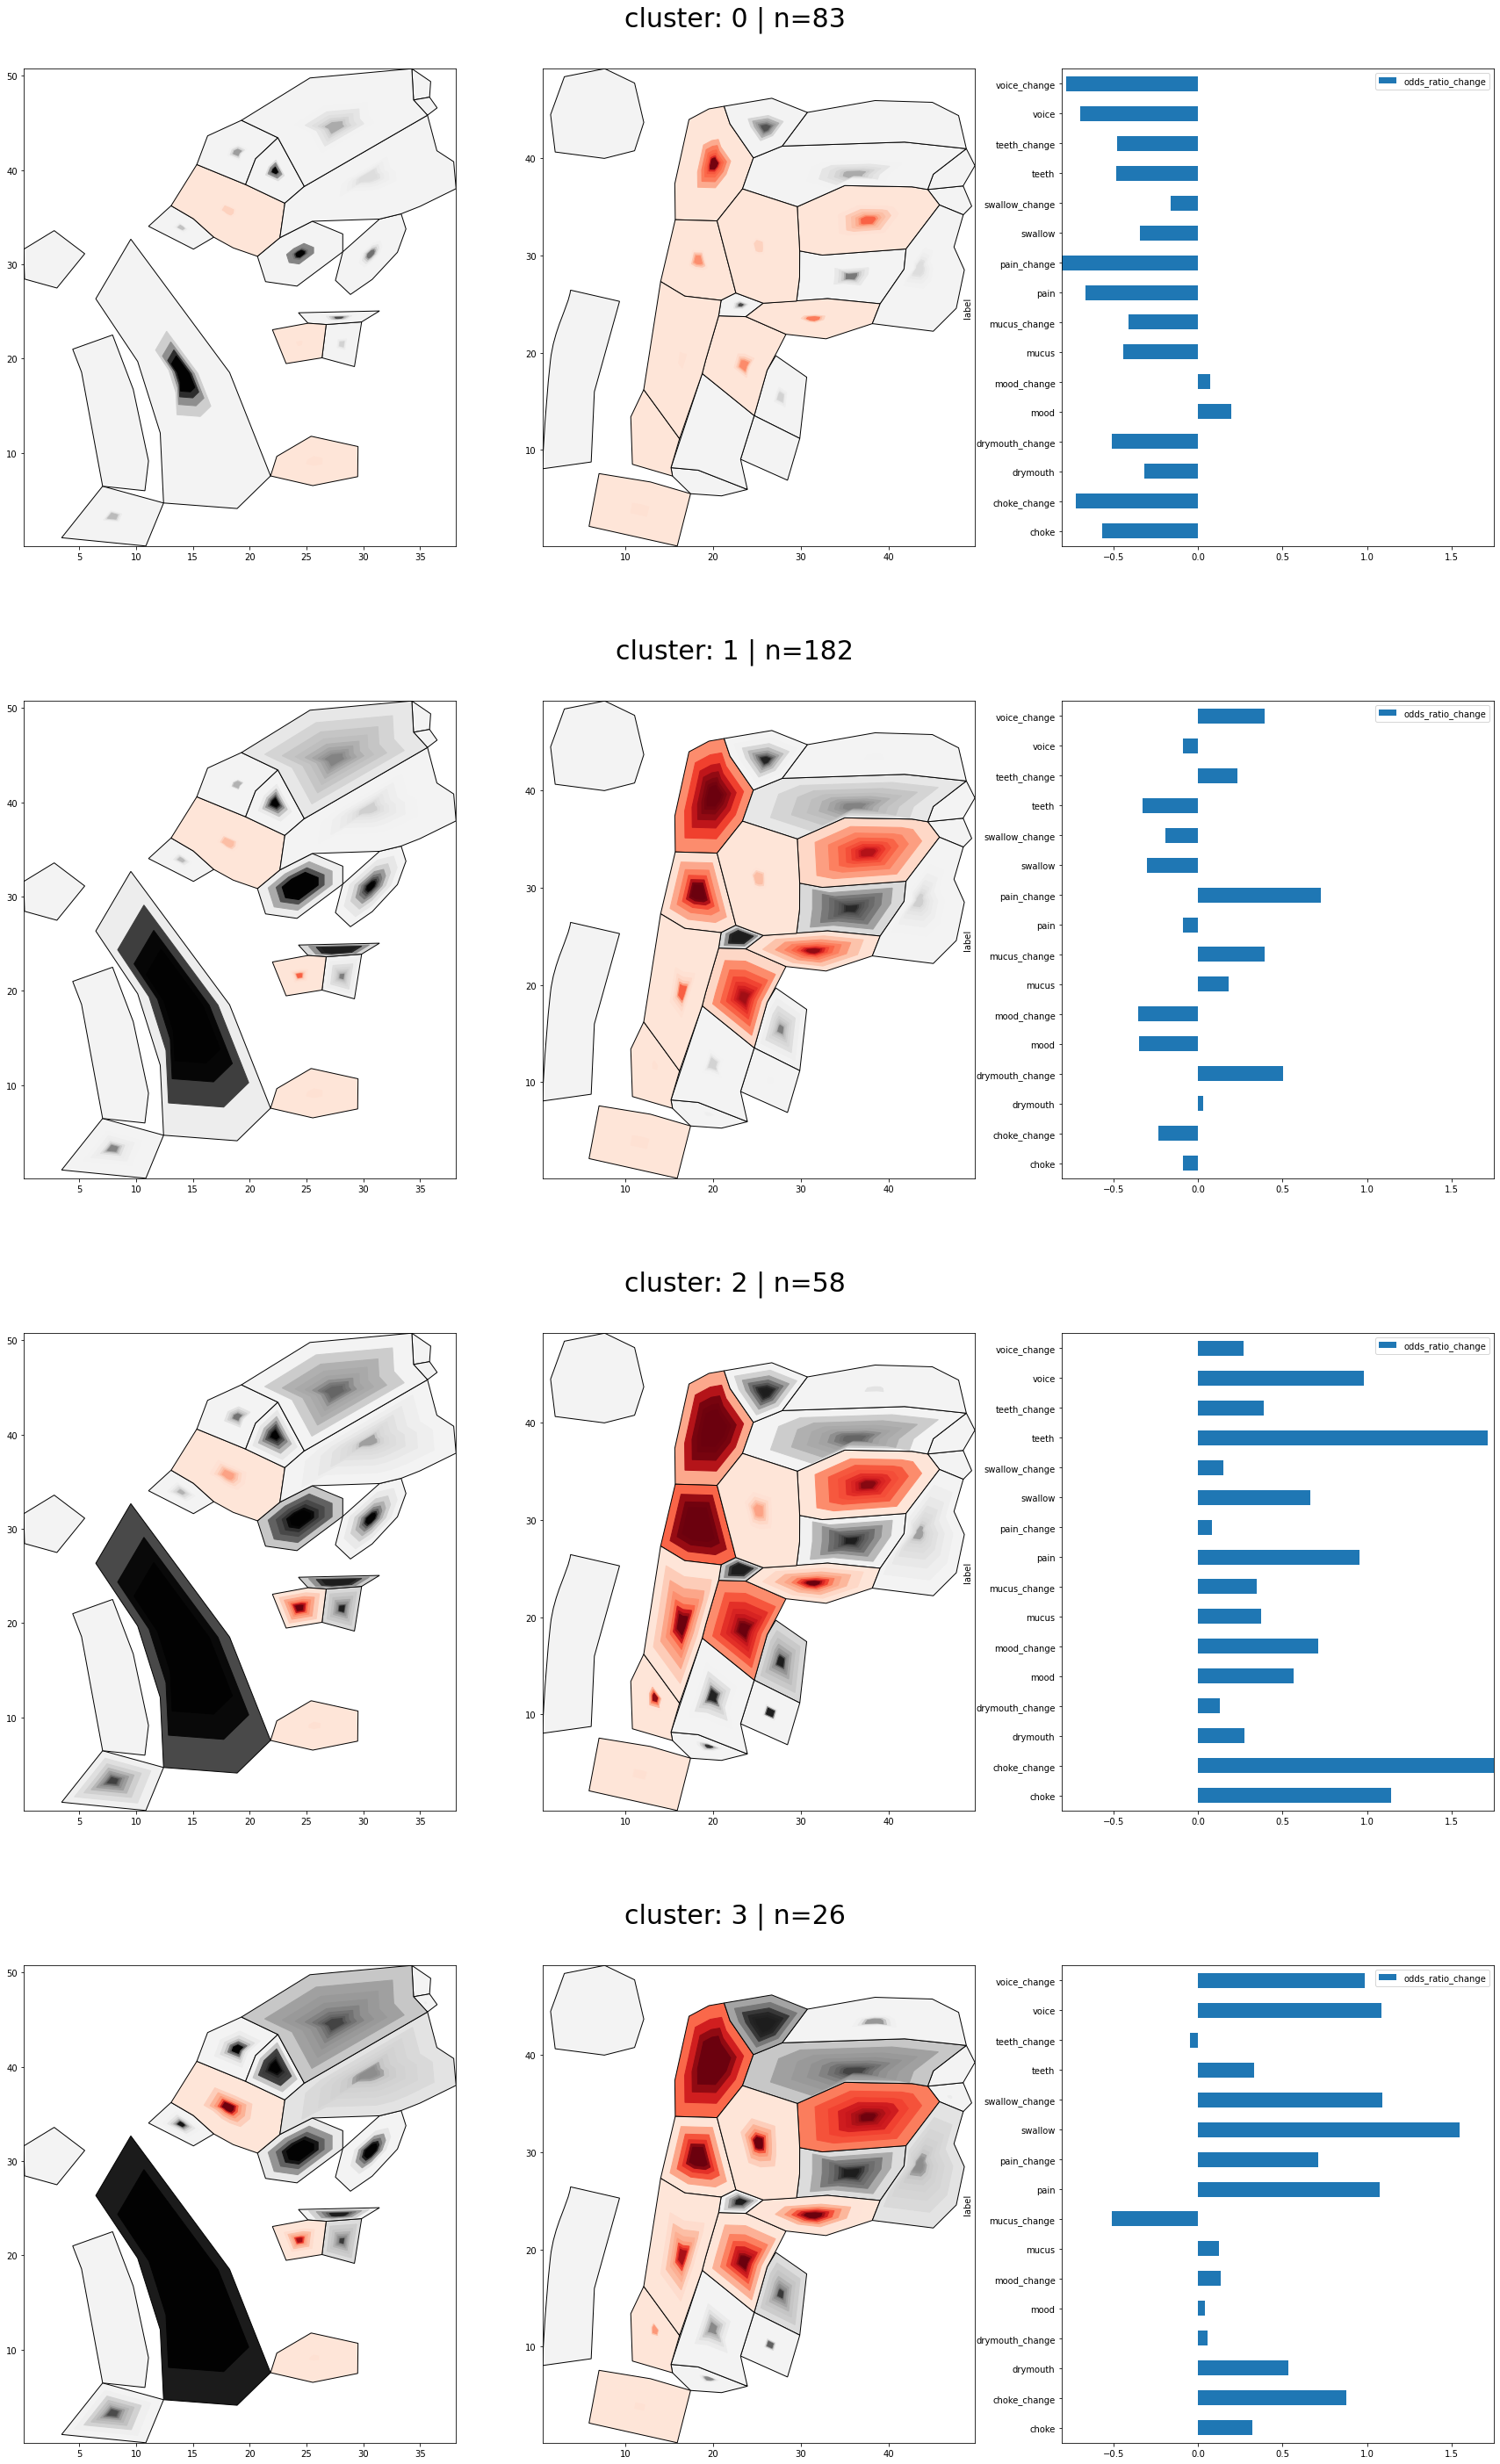

In [956]:
def load_organ_svg_file(svg_file,olist=None):
    doc = minidom.parse(svg_file)
    paths = {p.getAttribute('id'): p.getAttribute('d') for p in doc.getElementsByTagName('path')}
    if olist is not None:
        paths = {k:v for k,v in paths.items() if k in olist}
    return paths

def load_organ_paths(files=None,olist=None):
    if files is None:
        files = ['hnc_organs_center.svg',
                 'hnc_organs_right.svg',
                 'hnc_organs_left.svg'
                ]
    merged_dict = {}
    for file in files:
        try:
            d = load_organ_svg_file(file,olist)
            for k,v in d.items():
                merged_dict[k] = v
        except Exception as e:
            print(e)
    return merged_dict

def center_scale_path(path,scale):
    bbox = path.get_extents()
    left = (1-scale)*(bbox.x0 + bbox.x1)/2
    up = (1-scale)*(bbox.y0 + bbox.y1)/2
    tform = mplt.Affine2D().scale(scale) + mplt.Affine2D().translate(left,up) 
    path2 = mplt.TransformedPath(path,tform)
    return path2.get_fully_transformed_path()

def format_dose_clusters(df,
                         keys = ['V25','V35','V45','V55'],
                         merge_leftright=True,
                         cname='dose_clusters',
                         olist =None):
    df = df.copy()
    clusters = sorted(df[cname].unique())
    n_clusters = len(clusters)
    if olist is None:
        olist = Const.organ_list[:]
    odict = {o: Const.organ_list.index(o) for o in olist}
    opositions = [odict.get(o) for o in olist]
    key_scales = [1*(.75**i) for i in range(len(keys))]
    formatted = []
    
    colormapdict = {
        'Brainstem': 'Purples',
        'IPC': 'Reds',
        'MPC': "Reds",
        'SPC': "Reds",
        "Supraglottic_Larynx": "Reds",
        "Cricopharyngeal_Muscle": "Reds",
        "Esophagus": "Reds",
        "Mylogeniohyoid_M": "Reds",
        "Tongue": "Reds",
        "Rt_Masseter_M": "Reds",
        'Lt_Masseter_M': "Reds",
    }
    
    def getcolor(val, organ,maxval):
        cmap = colormapdict.get(organ,'Greys')
        if cmap == 'Greys':
            val = val*.5
        val = max(.1,min(val/maxval,.99))
#         val=.9
        c = plt.get_cmap(cmap)
        return c(val)
    
    for cluster, subdf in df.groupby(cname):
        for key,scale in zip(keys,key_scales):
            vals = subdf[key].apply(lambda x: np.array([x[i] for i in opositions]))
            vals = np.stack(vals.values)
            means = np.nanmean(vals,axis=0)
            for organ,mean in zip(olist,means):
                color = getcolor(mean,organ)
                entry = {'organ':organ,'key':key,'mean':mean,'scale': scale,'cluster':cluster,'color':color}
                formatted.append(entry)
    data = pd.DataFrame(formatted)
    if merge_leftright:
        data = merge_leftright_dose_entries(data,getcolor)
    return data

def merge_leftright_dose_entries(df,getcolor=None):
    df = df.copy()
    if getcolor is None:
        getcolor = lambda x,o: 'Red'
    base_names = [o.replace('Lt_','') for o in df.organ.unique() if 'Lt_' in o]
    for (key,cluster,scale), subdf in df.groupby(['key','cluster','scale']):
        for oname in base_names:
            left = "Lt_" + oname
            right = 'Rt_' + oname
            subsubdf = subdf[subdf.organ.apply(lambda x: x in [left,right])]
            assert(subsubdf.shape[0] == 2)
            new_mean = subsubdf['mean'].mean()
            color = getcolor(new_mean,left)
            merged_entry = {
                'key': key,
                'cluster': cluster,
                'mean': new_mean,
                'scale':scale,
                'organ': oname,
                'color': color
            }
            df=df.append(merged_entry,ignore_index=True)
    return df

def format_dose_clusters2(df,
                         key = 'V55',
                        quantiles=[.1,.2,.3,.4,.5,.6,.7,.8,.9],
                         merge_leftright=True,
                         cname='dose_clusters',
                         olist =None):
    df = df.copy()
    clusters = sorted(df[cname].unique())
    n_clusters = len(clusters)
    if olist is None:
        olist = Const.organ_list[:]
    odict = {o: Const.organ_list.index(o) for o in olist}
    opositions = [odict.get(o) for o in olist]
    quant_scales = [1*(.75**i) for i in range(len(quantiles))]
    formatted = []
    
    colormapdict = {
        'IPC': 'Reds',
        'MPC': "Reds",
        'SPC': "Reds",
        "Supraglottic_Larynx": "Reds",
        "Cricopharyngeal_Muscle": "Reds",
        "Esophagus": "Reds",
        "Mylogeniohyoid_M": "Reds",
        "Tongue": "Reds",
        "Rt_Masseter_M": "Reds",
        'Lt_Masseter_M': "Reds",
    }
    
    def getcolor(val, organ,maxval=80):
        cmap = colormapdict.get(organ,'Greys')
        if cmap == 'Greys':
            val = val*.9
        val = max(.1,min(val/maxval,.99))
#         val=.9
        c = plt.get_cmap(cmap)
        return c(val)
    
    to_vals = lambda d: np.stack(d[key].apply(lambda x: np.array([x[i] for i in opositions])).values)
    allvals = to_vals(df)
    maxval = allvals.max()
    for cluster, subdf in df.groupby(cname):
        vals = to_vals(subdf)
#         vals = np.stack(vals.values)
        qs = np.quantile(vals,quantiles,axis=0)
        for qname, quants, scale in zip(quantiles,qs,quant_scales):
            for organ,val in zip(olist,quants):
                color = getcolor(val,organ,maxval)
                entry = {'organ':organ,'key':qname,'mean':val,'scale': scale,'cluster':cluster,'color':color}
                formatted.append(entry)
    data = pd.DataFrame(formatted)
    if merge_leftright:
        data = merge_leftright_dose_entries(data,getcolor)
    return data

def plot_dose_clusters(df,
                       key='V45',
                       keys=['V25','V35','V45','V55','V65'],
                       use_histograms=False,
                       svg_files=None,
                        outcomes=None,
                        figscale=10,
                       cname='dose_clusters',
                       aggregate_sides = True,#just show mean sides instead of both
                      ):
    unformatted_df = df.copy()
    if outcomes is None:
        slist = ['pain','drymouth','swallow','choke','voice','teeth','mucus','mood']
        s_suffix = '_late'
        outcomes = [c for c in df.columns if 'symptom' in c and s_suffix in c and len(c) < 45 and np.any([s in c for s in slist])]
    odds_ratio_df = cluster_oddsratio(df,outcomes=outcomes,cname=cname,threshold=4)
    if use_histograms:
        df = format_dose_clusters(df,keys=keys,cname=cname)
    else:
        df = format_dose_clusters2(df,key=key,cname=cname)

    if svg_files is None:
        svg_files = Const.organ_svg_files[:]
        #skip the right side if we aggreage
        if aggregate_sides:
            svg_files = svg_files[0:2]
    pathdicts = [load_organ_svg_file(sf) for sf in svg_files]
    #doing only center first
    clist = sorted(df['cluster'].unique())
    n_rows = len(df.cluster.unique())
    n_cols = len(pathdicts) + 1
    fig = plt.figure(figsize=[figscale*n_cols,figscale*n_rows])
    subfigures= fig.subfigures(nrows=n_rows)#,ncols=n_cols)
    axes = []
    for c,subfig in zip(clist,subfigures):
        subplots = subfig.subplots(1,n_cols)
        counts = unformatted_df[unformatted_df[cname] == c].shape[0]
        subfig.suptitle('cluster: ' + str(c) + ' | n=' + str(counts),fontsize=3*figscale )
        axes.append(subplots)
    def update_extents(extent,p):
        bbox = p.get_extents()
        extent[0][0] = min(bbox.x0,extent[0][0])
        extent[0][1] = min(bbox.y0,extent[0][1])
        extent[1][0] = max(bbox.x1,extent[1][0])
        extent[1][1] = max(bbox.y1,extent[1][1])
        return extent
    for ax_col, pathdict in enumerate(pathdicts):
        extents = np.array([[np.inf,np.inf],[0,0]])
#         axes = subfigures.subplots(1,n_cols)
        for organ,v in pathdict.items():
            if aggregate_sides:
                organ = organ.replace("Lt_",'').replace("Rt_",'')
            path = parse_path(v)
            i = 0
            for c in clist:
                clustdf = df[df.cluster == c]
                ax = axes[i][ax_col]
                i += 1
                subdf = clustdf[clustdf.organ == organ]
                subdf = subdf.sort_values('scale',ascending=False)
                for dummy,row in subdf.iterrows():
                    color = row.color
                    scale = row.scale
                    new_path = center_scale_path(path,scale)
                    extents = update_extents(extents,path)
                    patch = mpatches.PathPatch(
                        new_path,
#                         color=color,
                        fc=color,
                        ec='black' if scale >= .99 else color,
                        alpha=.99,
                    )
                    ax.add_patch(patch)
                ax.set_xlim((extents[0][0],extents[1][0]))
                ax.set_ylim((extents[0][1],extents[1][1]))
                
    odds_ratio_df['odds_ratio_change'] = odds_ratio_df.odds_ratio - 1
    makelabel = lambda x: x.replace('symptoms_','').replace('_late','').replace('_post','').replace('_max','')
    odds_ratio_df['label'] = odds_ratio_df.outcome.apply(makelabel)
    odds_max = odds_ratio_df.odds_ratio_change.max()
    odds_min = odds_ratio_df.odds_ratio_change.min()
    for i,c in enumerate(clist):
        ax = axes[i][-1]
        outcome_df = odds_ratio_df[odds_ratio_df[cname] == c].fillna(0)
        outcome_df = outcome_df.sort_values('label')
        outcome_df.plot(
            kind='barh',
            y='odds_ratio_change',
            x='label',
            ax=ax,
            xlim=(odds_min,odds_max)
        )
    return 

# format_dose_clusters2(sd_df)
plot_dose_clusters(sd_df,
                   key='V50',
                   use_histograms=False,
                   cname='swallowing_4_dose_clusters')

In [ ]:
def plot_dose_radars(x,color_values=None,labels=None,**kwargs):
    #x should be n clusters x n_dimesions
    rescale = lambda i: (i-i.min())/(i.max()-i.min())
#     x = (x-x.min(axis=0))/(x.max(axis=0) - x.min(axis=0))
    chart_size = 2
    colormap = plt.get_cmap('tab10')
    if color_values is not None:
        colors = [colormap(c) for c in rescale(color_values)]
    else:
        colors = ['grey' for c in range(x.shape[0])]
    n_cols = x.shape[-1]
    n_clusters = x.shape[0]
    n_channels = x.shape[1]
    figsize = [n_cols*chart_size*1.2,n_cols*chart_size]
    fig,ax = plt.subplots(1,x.shape[0],figsize=figsize,
                         subplot_kw={'projection': 'polar'})
    
    n_channels = x.shape[1]
    angles = [2*np.pi*n/n_cols for n in range(n_cols)]
    angles += angles[:1]
    for i in range(n_clusters):
        row = x[i]
        curr_ax = ax[i]
        color = colors[i]
        for channel in range(n_channels):
            vals = list(row[channel])
            vals = vals + [vals[0]]
            curr_ax.plot(angles,vals,color=color,linewidth=channel*2)
    return
                
def plot_dose_clusters(df,keys=['mean_dose','V65'],olist=None,cname='dose_clusters'):
    if olist is None:
        olist = Const.organ_list
    odict = {o: Const.organ_list.index(o) for o in olist}
    clusters = df.dose_clusters.unique()
    axes = []
    clust_vals = []
    for cluster, clustdf in df.groupby('dose_clusters'):
        row = []
        for key in keys:
            keyrow=[]
            avg = clustdf[key].values
            avg = np.stack([np.array(v) for v in avg])
            avg = np.nan_to_num(avg.astype(float))
            avg = np.mean(avg,axis=0)
            for organ in olist:
                opos = odict[organ]
                keyrow.append(avg[opos])
            row.append(np.array(keyrow))
        clust_vals.append(np.array(row))
    clust_vals = np.nan_to_num(np.array(clust_vals))
    plot_dose_radars(clust_vals)
                
plot_dose_clusters(sd_df,cname='swallow_dose_clusters')

In [133]:
def get_dvhcol_pos(x):
    m = re.match('[DV]'+'(\d+)',x)
    if m is not None:
        return int(m.group(1))
    else:
        return -1
    
def get_dvh_columns(dvh,key,steps=None):
    good_cols = []
    for c in dvh.columns:
        match = re.match(key+'(\d+)', c)
        if match is not None:
            use = True
            if steps is not None and match.group(1) is not None:
                value = int(match.group(1))
                if value not in steps:
                    use = False
            if use:
                good_cols.append(match.group(0))
    keys = sorted(good_cols, key = get_dvhcol_pos)
    pos = [get_dvhcol_pos(x) for x in good_cols]
    return keys

def get_logit_corr_df(df, xcol, ycol, covars=[]):
    #multivariate regression t-value and p-value for binary outcome
    try:
        varlist = sorted(set(covars + [xcol]))
        x = df[varlist].fillna(0)
        y = df[ycol].astype(bool)
        logit = sm.GLM(y,x,disp=False)
        logit_res = logit.fit(disp=False)
        pvals = logit_res.pvalues
        tvals = logit_res.tvalues
        return tvals[xcol], pvals[xcol]
    except Exception as e:
        print(e)
        return 0, 1
    
def get_logit_corr(x, y, covars=None,regularize=True):
    #multivariate regression t-value and p-value for binary outcome
    try:
        if covars is not None:
            x =np.concatenate((x.reshape(-1,1),covars),axis=1)
        x =np.nan_to_num(x)
        if regularize:
            x = (x-x.mean(axis=0))/x.std(axis=0)
        x =np.nan_to_num(x)
        logit = sm.Logit(y,x,disp=False)
        logit_res = logit.fit(disp=False)
        pvals = logit_res.pvalues
        tvals = logit_res.tvalues
        return tvals[0],pvals[0]
    except Exception as e:
        print(e)
        return 0, 1
    

def get_correlations(sddf,
                     olist=None,
                     organ_cols=None,
                     categorical_inputs = ['dose_clusters'],
                     categorical_predictors = ['symptom_clusters','dose_clusters'],
                     covariates=['t4','n3','old'],
                     predictors=None,
                     threshold=5,
                     symptoms=None):
    #needs the right organ list, just in case I need that some time, should always be mapped to constants really
    sddf = sddf.copy().sort_index()
    covars = sddf[covariates].fillna(0).values
    if olist is None:
        olist = Const.organ_list
    odict = {o: Const.organ_list.index(o) for o in olist}
    if predictors is None:
        predictors = []
    if symptoms is None or len(symptoms) > 0:
        psuffixes = ['_all','_treatment','_post','_late']
        spredictors = [s for s in sddf.columns if np.any([p in s for p in psuffixes])]
        spredictors = [p for p in spredictors if np.any([s in p for s in symptoms])]
        predictors = predictors + spredictors

    if organ_cols is None:
        organ_cols = get_dvh_columns(sddf,'V') + ['mean_dose']
        
    def get_correlations(df,x,predictor,thresh=None):
        pvals = df[predictor].values
        if thresh is not None:
            pvals = (pvals >= thresh).astype(int)
        chi2corr, pval = vector_chi2(x,pvals)
        if len(np.unique(pvals)) < 3:
            pearsoncorr,pearsonp = pointbiserialr(pvals,x)
        else:
            pearsoncorr,pearsonp = pearsonr(x,pvals)
        nonlocal covars
        multivar_t, multivar_p = get_logit_corr(x,pvals,covars=covars)
        res = {
            'chi2':chi2corr,
            'chi2_pval':pval,
            'outcome':predictor,
            'pearson': pearsoncorr,
            'pearson_pval': pearsonp,
            'logit_tval': multivar_t,
            'logit_pval': multivar_p,
        }
        #need a main-pvalue depending on if the input is continuous or not
        if len(np.unique(x)) < 3:
            res['pval'] = pval
        else:
            res['pval'] = pearsonp
        return res
    
    results = []
    
    def print_entry(e):
        print(e['xvalue'],'-',e['organ'],'-->',e['outcome'],'|',np.sign(e['pearson'])*e['logit_pval'])
        print()
        
    def check_bad_entry(e):
        if e['logit_tval'] == 0 and e['logit_pval'] == 1:
            print('bad matrix for', e['xvalue'],'-',e['organ'],'-->',e['outcome'],'|',entry['pval'])
            print()
        
    if categorical_inputs is not None:
        for col in categorical_inputs:
            basevals = sddf[col].values
            dummy_df = pd.get_dummies(sddf[col],prefix=col)
            xval_list = [(subcol,dummy_df[subcol].values) for subcol in dummy_df.columns]
            xval_list = [(col,basevals)] + xval_list
            for colname, xvals in xval_list:
                if categorical_predictors is not None:
                    for cp in categorical_predictors:
                        if cp == col:
                            continue
                        drop = bool(len(sddf[cp].unique()) < 3)
                        outcome = pd.get_dummies(sddf[cp],prefix=cp,drop_first=drop)
                        for cp_col in outcome.columns:
                            entry = get_correlations(outcome,xvals,cp_col,None)
                            entry['organ'] = ''
                            entry['xvalue'] = colname
                            if entry['logit_pval'] < .01:
                                print_entry(entry)
                            check_bad_entry(entry)
                            results.append(entry)
                for predictor in predictors:
                    entry = get_correlations(sddf,xvals,predictor,threshold)
                    entry['organ'] = ''
                    entry['xvalue'] = colname
                    if entry['logit_pval'] < .01:
                        print_entry(entry)
                    check_bad_entry(entry)
                    results.append(entry)
                    
    for x_col in organ_cols:
        x = np.stack([np.array(v) for v in sddf[x_col].values])
        for organ, opos in odict.items():
            ovals = x[:,opos]
            if np.std(ovals) <= .00001:
                continue
            if categorical_predictors is not None:
                for cp in categorical_predictors:
                    drop = (bool(len(sddf[cp].unique()) < 3))
                    outcome = pd.get_dummies(sddf[cp],prefix=cp,drop_first=drop)
                    for cp_col in outcome.columns:
                        entry = get_correlations(outcome,ovals,cp_col,None)
                        entry['organ'] = organ
                        entry['xvalue'] = x_col
                        if entry['logit_pval'] < .000001:
                            print_entry(entry)
                        check_bad_entry(entry)
                        results.append(entry)
            for predictor in predictors:
                #these should be 1 dimensional
                entry = get_correlations(sddf,ovals,predictor,threshold)
                entry['organ'] = organ
                entry['xvalue'] = x_col
                if entry['logit_pval'] < .000001:
                    print_entry(entry)
                check_bad_entry(entry)
                results.append(entry)
                
    return pd.DataFrame(results)
    
organ_list = [
    'Esophagus',
    'Brainstem',
    'Spinal_Cord',
    'SPC',
    'IPC',
    'MPC',
    'Lower_Lip',
    'Supraglottic_Larynx',
    'Glottic_Area',
    'Tongue'
]
symptoms = [
    'nausea',
    'pain',
    'drymouth',
    'vomit',
    'swallow',
    'choke',
    'voice',
    'mood',
]
organ_cols = ['mean_dose','V65','V55','V45','V35','V25','V15']
sddf_correlations = get_correlations(sd_df,
                                     organ_cols = organ_cols,
                                     symptoms = symptoms,
#                                      categorical_inputs=None,
#                                      categorical_predictors=None,
#                                      olist = organ_list,
                                    )
sddf_correlations

dose_clusters -  --> symptoms_pain_max_change_all | -0.0029258830541156436

dose_clusters -  --> symptoms_pain_max_change_treatment | -0.0019303025999961232

dose_clusters_1 -  --> symptoms_pain_max_change_all | 0.0044361679996094945

dose_clusters_1 -  --> symptoms_pain_max_change_treatment | 0.001209997574413958

dose_clusters_3 -  --> symptoms_choke_max_change_all | -0.008395644855691222

dose_clusters_3 -  --> symptoms_swallow_max_change_treatment | -0.0045264069557468594

dose_clusters_5 -  --> symptoms_choke_drymouth_swallow_teeth_voice_max_late | -0.0031607511172750936

dose_clusters_5 -  --> symptoms_choke_drymouth_swallow_teeth_voice_max_change_late | -0.0075295513359089844

mean_dose - Spinal_Cord --> dose_clusters_3 | -7.027732641894001e-09

mean_dose - Rt_Brachial_Plexus --> dose_clusters_1 | 7.98957069516973e-07

mean_dose - Rt_Brachial_Plexus --> dose_clusters_3 | -1.1202783324026235e-13

mean_dose - Cricopharyngeal_Muscle --> dose_clusters_1 | 1.2290751256449524e-07

mea

V45 - MPC --> dose_clusters_1 | 5.274099745718275e-09

V45 - MPC --> dose_clusters_3 | -2.714501080089853e-07

V45 - Rt_Sternocleidomastoid_M --> dose_clusters_3 | -3.567744854195872e-15

V45 - Rt_Medial_Pterygoid_M --> dose_clusters_3 | -2.163280841794692e-09

V45 - Lt_Sternocleidomastoid_M --> dose_clusters_1 | 4.1034045881928894e-07

V45 - Supraglottic_Larynx --> dose_clusters_1 | 3.3147560242339794e-10

V45 - Supraglottic_Larynx --> dose_clusters_3 | -2.481513433929066e-07

V45 - SPC --> dose_clusters_0 | -2.632622102708994e-07

V45 - SPC --> dose_clusters_1 | 1.0381452927224054e-07

V45 - SPC --> dose_clusters_3 | -1.2024589012235907e-07

V45 - Rt_Submandibular_Gland --> dose_clusters_1 | 1.8550601263653057e-08

V45 - Rt_Submandibular_Gland --> dose_clusters_3 | -9.121293912156953e-14

V45 - Hyoid_bone --> dose_clusters_1 | 5.597299692655626e-11

V45 - Hyoid_bone --> dose_clusters_3 | -1.8010370933809937e-08

V45 - Genioglossus_M --> dose_clusters_1 | 1.062605732773393e-09

V45 - 

chi2  chi2_pval  \
0        2.664363   0.751563   
1        9.211899   0.100905   
2        2.909992   0.713860   
3        4.704418   0.453007   
4        9.442379   0.092668   
...           ...        ...   
28168  129.039912   0.628341   
28169  134.040767   0.507143   
28170  134.422621   0.497841   
28171  122.058642   0.780340   
28172  127.994317   0.652912   

                                                 outcome   pearson  \
0                                     symptom_clusters_0 -0.048723   
1                                     symptom_clusters_1  0.051197   
2                                     symptom_clusters_2  0.051226   
3                                     symptom_clusters_3  0.005964   
4                                     symptom_clusters_4 -0.063228   
...                                                  ...       ...   
28168  symptoms_activity_distress_enjoy_fatigue_mood_... -0.047776   
28169  symptoms_activity_distress_enjoy_fatigue_mood_...  0.022784   
28170  symptoms_activity_distress_enjoy_fatigue_mood_...  0.017540   
28171  symptoms_activity_distress_enjoy_fatigue_mood_...  0.072546   
28172  symptoms_activity_distress_enjoy_fatigue_mood_...  0.018539   

       pearson_pval  logit_tval  logit_pval      pval         organ  \
0          0.364149   -0.411642    0.680602  0.364149                 
1          0.340268    0.762090    0.446006  0.340268                 
2          0.339993    0.806603    0.419895  0.339993                 
3          0.911605   -0.127451    0.898583  0.911605                 
4          0.238738   -1.036241    0.300090  0.238738                 
...             ...         ...         ...       ...           ...   
28168      0.373553   -1.055708    0.291102  0.373553  Glottic_Area   
28169      0.671438    0.375887    0.707001  0.671438  Glottic_Area   
28170      0.744033    0.250667    0.802071  0.744033  Glottic_Area   
28171      0.176312    1.066341    0.286269  0.176312  Glottic_Area   
28172      0.729996    0.078718    0.937257  0.729996  Glottic_Area   

              xvalue  
0      dose_clusters  
1      dose_clusters  
2      dose_clusters  
3      dose_clusters  
4      dose_clusters  
...              ...  
28168            V15  
28169            V15  
28170            V15  
28171            V15  
28172            V15  

[28173 rows x 10 columns]

In [139]:
def print_max(temp_df,key='logit_pval'):
    temp = temp_df.sort_values(key,ascending=True)
    row = temp.iloc[0]
    print(row['xvalue'],"+",row['organ'],'-->',row['outcome'],
          "|",row[key]*np.sign(row['pearson']))
    
for outcome, subdf in sddf_correlations.groupby('outcome'):
    if 'cluster' not in outcome:
        continue
    print_max(subdf)
print()

for outcome, subdf in sddf_correlations.groupby('outcome'):
    if '_change_post' not in outcome:
        continue
    print_max(subdf)
print()

for outcome, subdf in sddf_correlations.groupby('outcome'):
    if '_change_late' not in outcome:
        continue
    print_max(subdf)  
print()

for outcome, subdf in sddf_correlations.groupby('outcome'):
    if '_change_treatment' not in outcome:
        continue
    print_max(subdf)

V45 + Upper_Lip --> dose_clusters_0 | 1.1652845714216627e-07
V65 + Hyoid_bone --> dose_clusters_1 | 3.6727581965961674e-15
V25 + Cricopharyngeal_Muscle --> dose_clusters_2 | -3.4627999160967483e-06
V15 + Rt_Submandibular_Gland --> dose_clusters_3 | -1.7301244668617148e-28
V65 + Lower_Lip --> dose_clusters_4 | 2.530472680428513e-27
V65 + Spinal_Cord --> dose_clusters_5 | 2.2953356981913855e-32
V65 + Cricopharyngeal_Muscle --> symptom_clusters_0 | 0.12219329890992313
V25 + Spinal_Cord --> symptom_clusters_1 | -0.009392707312560707
V65 + Lower_Lip --> symptom_clusters_2 | 6.855843536364284e-20
V35 + Lt_Ant_Digastric_M --> symptom_clusters_3 | 0.04601249932265312
mean_dose + Brainstem --> symptom_clusters_4 | 0.0006383539397506382

V65 + Lower_Lip --> symptoms_activity_distress_enjoy_fatigue_mood_sad_sob_max_change_post | 2.815170151772686e-20
V35 + Thyroid_cartilage --> symptoms_choke_drymouth_swallow_teeth_voice_max_change_post | 0.00010646850845387712
V65 + Brainstem --> symptoms_choke_

In [231]:
outcomes =  ['symptom_clusters_' + str(i) for i in range(5)]
outcomes = outcomes + [
    'symptoms_choke_drymouth_swallow_teeth_voice_max_post',
#     'symptoms_choke_drymouth_swallow_teeth_voice_max_treatment',
    'symptoms_pain_max_post',
#     'symptoms_pain_max_treatment',
                      ]
# outcomes = outcomes + [
#     'symptoms_choke_drymouth_swallow_teeth_voice_max_change_post',
#     'symptoms_choke_drymouth_swallow_teeth_voice_max_change_treatment',
#     'symptoms_pain_max_change_post',
#     'symptoms_pain_max_change_treatment',
#                       ]
for cluster in outcomes:
    subdf = sddf_correlations[sddf_correlations.outcome == cluster]
    subdf = subdf.sort_values('logit_pval',ascending=True)
    subdf = subdf.drop_duplicates(subset=['organ'],keep='first')
#     subdf = subdf.iloc[0:8]
    subdf = subdf[subdf.logit_pval < .005]
    print(cluster)
    print(' | '.join(subdf.organ.unique()))
    print(subdf[['organ','xvalue','logit_pval','pval','pearson']])
    print()

symptom_clusters_0

Empty DataFrame
Columns: [organ, xvalue, logit_pval, pval, pearson]
Index: []

symptom_clusters_1

Empty DataFrame
Columns: [organ, xvalue, logit_pval, pval, pearson]
Index: []

symptom_clusters_2
Lower_Lip | Spinal_Cord | Brainstem | Lt_Mastoid
             organ xvalue    logit_pval      pval   pearson
8177     Lower_Lip    V65  6.855844e-20  0.549625  0.094472
4613   Spinal_Cord    V65  6.855844e-20  0.549625  0.094472
5306     Brainstem    V65  6.855844e-20  0.549625  0.094472
22037   Lt_Mastoid    V25  3.491876e-03  0.000301 -0.192379

symptom_clusters_3

Empty DataFrame
Columns: [organ, xvalue, logit_pval, pval, pearson]
Index: []

symptom_clusters_4
Brainstem | Spinal_Cord | Upper_Lip | Rt_Lateral_Pterygoid_M | Lt_Mastoid | Esophagus | Rt_Mastoid
                        organ     xvalue  logit_pval      pval   pearson
1447                Brainstem  mean_dose    0.000638  0.000109  0.205688
20356             Spinal_Cord        V25    0.000965  0.000149  0.2016

In [215]:
outcomes =  ['dose_clusters_' + str(i) for i in range(5)]
for cluster in outcomes:
    subdf = sddf_correlations[sddf_correlations.xvalue == cluster].copy()
    subdf = subdf.sort_values('logit_pval',ascending=True)
    subdf = subdf.drop_duplicates(subset=['outcome'],keep='first')
    subdf = subdf[subdf.logit_pval < .05]
    if subdf.shape[0] < 1:
        continue
#     subdf = subdf[subdf.outcome.apply(lambda x: 'change_post' in x)]#subdf.iloc[0:8]
    subdf['label'] = subdf.outcome.apply(lambda x: x.replace('_max_change_post',''))
#     subdf['value'] = subdf.apply(lambda x: x['logit_pval'] * np.sign(x['pearson']),axis=1)
    print(cluster)
    print(subdf[['label','logit_pval','logit_tval']])
    print()

dose_clusters_0
                             label  logit_pval  logit_tval
150  symptoms_voice_max_change_all    0.039211    2.061963

dose_clusters_1
                                                 label  logit_pval  logit_tval
228                 symptoms_pain_max_change_treatment    0.001210    3.236513
227                       symptoms_pain_max_change_all    0.004436    2.845357
205                                  symptoms_drymouth    0.014641    2.441135
206                  symptoms_drymouth_max_change_late    0.015173    2.428218
262  symptoms_choke_drymouth_swallow_teeth_voice_ma...    0.025086    2.240072
261        symptoms_choke_drymouth_swallow_teeth_voice    0.032670    2.136114

dose_clusters_3
                                                 label  logit_pval  logit_tval
422              symptoms_swallow_max_change_treatment    0.004526   -2.838937
381                      symptoms_choke_max_change_all    0.008396   -2.635730
378                       symptoms_choke_m

In [222]:
organs = Const.organ_list#['Brainstem','MPC','Lt_Brachial_Plexus','Tongue']
for organ in organs:
    subdf = sddf_correlations[sddf_correlations.organ == organ].copy()
    subdf = subdf.sort_values('logit_pval',ascending=True)
    subdf = subdf.drop_duplicates(subset=['outcome'],keep='first')
    subdf = subdf[subdf.logit_pval < .05]
    if subdf.shape[0] < 1:
        continue
    subdf = subdf[subdf.outcome.apply(lambda x: '_post' in x)]#subdf.iloc[0:8]
    subdf['label'] = subdf.outcome.apply(lambda x: x.replace('_max_change',''))
    print(organ)
    print(subdf[['label','xvalue','logit_pval','logit_tval']])
    print()

Esophagus
Empty DataFrame
Columns: [label, xvalue, logit_pval, logit_tval]
Index: []

Spinal_Cord
                                                   label xvalue  logit_pval  \
20378                             symptoms_drymouth_late    V25    0.003057   
20434   symptoms_choke_drymouth_swallow_teeth_voice_late    V25    0.005740   
4689   symptoms_choke_drymouth_swallow_teeth_voice_ma...    V65    0.010283   
20374                         symptoms_drymouth_max_late    V25    0.024662   

       logit_tval  
20378    2.961979  
20434    2.762264  
4689    -2.566168  
20374    2.246649  

Lt_Brachial_Plexus
                                                   label xvalue  logit_pval  \
16573   symptoms_choke_drymouth_swallow_teeth_voice_late    V35    0.000602   
16517                             symptoms_drymouth_late    V35    0.001046   
16569  symptoms_choke_drymouth_swallow_teeth_voice_ma...    V35    0.003602   
16513                         symptoms_drymouth_max_late    V35    0.0